In [1]:
import os
import json
import pandas as pd
from collections import defaultdict

# Process Dataset Snapshot

### Load and process images.csv columns

In [2]:
data = pd.read_csv('/data/old-data/database/images.csv')
data.head()

,id,width,height,created_at,updated_at,tags,fingerprint,dataset_upload_id,crop,tag_keys
0,6571310,640,799,2019-08-10 11:46:06.725274,2019-12-19 00:33:38.04658,"{source:instagram,instagram:darkspots,upload-d...",-8122440064975953702,4660.0,NaN,"{instagram,studio,prediction,source,upload-date}"
1,1026825,720,720,2018-08-07 00:57:39.254922,2019-12-18 18:27:16.764652,"{facebook:alopecia-areata,name:healthy-skin,da...",8081097819320648603,2427.0,NaN,"{data-team,facebook,key,mturk-reviewed,name,so..."
2,6948943,1891,1891,2020-02-26 23:26:39,2020-02-26 23:36:23.008338,"{model:first-gate,app-id:81b51c29-e778-414f-9e...",-8747699706149567965,NaN,"{0,334,1891,1891}","{model,app-id,first-gate-top1,first-gate-top2,..."
3,6571812,750,750,2019-08-10 11:52:40.865757,2019-12-19 00:33:43.207483,"{source:instagram,instagram:darkspots,upload-d...",7829801292191152947,4660.0,NaN,"{instagram,prediction,source,upload-date}"
4,6948945,483,483,2020-02-26 23:29:12,2020-07-31 16:13:24.065983,"{model:first-gate,app-id:b8c2ca33-67b1-4b9a-be...",-4497303361408919818,NaN,"{22,420,483,483}","{model,app-id,first-gate-top1,first-gate-top2,..."


In [3]:
len(data)

1803654

In [4]:
def parse_db_tags(tags_string):
    tags_dict = defaultdict(set)
    tags_string = tags_string[1:-1]
    tags_list = tags_string.split(',')
    for i in range(len(tags_list)):
        try:
            key, value = tags_list[i].split(':')
            tags_dict[key].add(value)
        except:
            # Errors like consensus:3-review-status:dermatologist-reviewed
            tags_list_error = tags_list[i].split(':')
            if tags_list_error[0] == 'consensus':
                tags_dict['consensus'].add(3)
                tags_dict['review-status'].add('dermatologist-reviewed')
            # Errors like ['facebook', 'seborrheic-dermatitis--worse-than-dandruff-', '-']
            elif tags_list_error[0] == 'facebook':
                tags_dict['facebook'].add(tags_list_error[0])
                tags_dict['review-status'].add(tags_list_error[1])
                tags_dict['review-status'].add(tags_list_error[2])
    return tags_dict

def parse_crop(crop_string):
    if not pd.isnull(crop_string):
        return list(map(int, crop_string[1:-1].split(','))

def parse_tag_keys(tag_keys_string):
    if not pd.isnull(tag_keys_string):
        return set(tag_keys_string[1:-1].split(','))

In [8]:
data.at[:, 'tags'] = data['tags'].map(lambda x: parse_db_tags(x))

In [9]:
data.at[:, 'crop'] = data['crop'].map(lambda x: parse_crop(x))

In [10]:
data.at[:, 'tag_keys'] = data['tag_keys'].map(lambda x: parse_tag_keys(x))

In [11]:
data.head()

,id,width,height,created_at,updated_at,tags,fingerprint,dataset_upload_id,crop,tag_keys
0,6571310,640,799,2019-08-10 11:46:06.725274,2019-12-19 00:33:38.04658,"{'source': {'instagram'}, 'instagram': {'darks...",-8122440064975953702,4660.0,None,"{studio, instagram, upload-date, source, predi..."
1,1026825,720,720,2018-08-07 00:57:39.254922,2019-12-18 18:27:16.764652,"{'facebook': {'alopecia-areata'}, 'name': {'he...",8081097819320648603,2427.0,None,"{name, facebook, key, data-team, source, mturk..."
2,6948943,1891,1891,2020-02-26 23:26:39,2020-02-26 23:36:23.008338,"{'model': {'first-gate'}, 'app-id': {'81b51c29...",-8747699706149567965,NaN,"[0, 334, 1891, 1891]","{first-gate-top1, first-gate-top4, first-gate-..."
3,6571812,750,750,2019-08-10 11:52:40.865757,2019-12-19 00:33:43.207483,"{'source': {'instagram'}, 'instagram': {'darks...",7829801292191152947,4660.0,None,"{instagram, source, prediction, upload-date}"
4,6948945,483,483,2020-02-26 23:29:12,2020-07-31 16:13:24.065983,"{'model': {'first-gate'}, 'app-id': {'b8c2ca33...",-4497303361408919818,NaN,"[22, 420, 483, 483]","{studio, quality-checker, first-gate-top1, rev..."


### Process reviews.csv

In [16]:
def process_reviews_df(reviews_df):
    image_id_diagnoses = defaultdict(list)
    bad_derm = defaultdict(lambda: 0)
    for i, row in reviews_df.iterrows():
        confidence = 0
        diag_dict = {}
        # That reviewer must be removed
        if row['user_id'] == 99:
            continue
        if row['diagnoses'] != '[]':
            diagnoses = json.loads(row['diagnoses'])
            for diagnosis in diagnoses:
                if diagnosis['tag'] == 'AIP:0000411':
                    bad_derm[row['user_id']] += 1
                diagnosis_key = diagnosis['tag']
                diagnosis_value = diagnosis['confidence']
                confidence += diagnosis['confidence']
                diag_dict.update({diagnosis_key: diagnosis_value})
            if confidence < 100:
                diag_dict.update({'uncertainty': 100 - confidence})
        else:
            diag_dict = {'uncertainty': 100}
        review_dict = {'image_type': row['image_type'], 'diagnoses': diag_dict, 'reviewer_email': row['user_id']}
        bad_quality = not row['bad_quality'] == 'f'
        review_dict.update({'bad_quality': bad_quality})
        image_id_diagnoses[row['image_id']].append(review_dict)
    return image_id_diagnoses
    

In [12]:
reviews_df = pd.read_csv('/data/old-data/database/review_labelling_responses.csv')

In [13]:
reviews_df.head()

,id,assignment_id,user_id,image_id,diagnoses,bad_quality,created_at,updated_at,image_type
0,16,7,16,360,[],f,2019-12-09 16:24:43.96388,2019-12-09 16:24:43.96388,dermoscopic
1,17,7,16,469,[],f,2019-12-10 12:20:20.625766,2019-12-10 12:20:20.625766,macroscopic
2,32,14,16,3111517,[],f,2019-12-10 20:57:22.4208,2019-12-10 20:57:22.4208,macroscopic
3,38,7,16,829,"[{""tag"": ""AIP:0100041"", ""name"": ""flexural ecze...",f,2019-12-11 14:31:39.931978,2019-12-11 14:31:39.931978,macroscopic
4,39,7,16,1222,[],t,2019-12-11 14:31:45.042759,2019-12-11 14:31:45.042759,NaN


In [17]:
image_id_diagnoses = process_reviews_df(reviews_df)

### Append reviews data to the images data df 

In [21]:
data['reviews'] = None

In [23]:
data

,id,width,height,created_at,updated_at,tags,fingerprint,dataset_upload_id,crop,tag_keys,reviews
0,6571310,640,799,2019-08-10 11:46:06.725274,2019-12-19 00:33:38.04658,"{'source': {'instagram'}, 'instagram': {'darks...",-8122440064975953702,4660.0,None,"{studio, instagram, upload-date, source, predi...",None
1,1026825,720,720,2018-08-07 00:57:39.254922,2019-12-18 18:27:16.764652,"{'facebook': {'alopecia-areata'}, 'name': {'he...",8081097819320648603,2427.0,None,"{name, facebook, key, data-team, source, mturk...",None
2,6948943,1891,1891,2020-02-26 23:26:39,2020-02-26 23:36:23.008338,"{'model': {'first-gate'}, 'app-id': {'81b51c29...",-8747699706149567965,NaN,"[0, 334, 1891, 1891]","{first-gate-top1, first-gate-top4, first-gate-...",None
3,6571812,750,750,2019-08-10 11:52:40.865757,2019-12-19 00:33:43.207483,"{'source': {'instagram'}, 'instagram': {'darks...",7829801292191152947,4660.0,None,"{instagram, source, prediction, upload-date}",None
4,6948945,483,483,2020-02-26 23:29:12,2020-07-31 16:13:24.065983,"{'model': {'first-gate'}, 'app-id': {'b8c2ca33...",-4497303361408919818,NaN,"[22, 420, 483, 483]","{studio, quality-checker, first-gate-top1, rev...",None
...,...,...,...,...,...,...,...,...,...,...,...
1803649,7095725,1029,1029,2020-08-19 05:25:34,2020-08-19 06:13:21.204651,"{'model': {'macroscopic', 'first-gate'}, 'app-...",1425060984306558659,NaN,"[453, 1373, 1029, 1029]","{macroscopic-top3, bydef-are-there-blisters-or...",None
1803650,7095726,2915,2915,2020-08-19 06:06:17,2020-08-19 07:28:21.368471,"{'model': {'macroscopic', 'first-gate'}, 'app-...",110340280308760575,NaN,"[1683, 704, 2915, 2915]","{macroscopic-top3, studio, user-id, bydef-do-y...",None
1803651,7095728,1958,1958,2020-08-19 07:18:14,2020-08-19 07:43:21.491695,"{'model': {'macroscopic', 'first-gate'}, 'app-...",2953417884195116416,NaN,"[108, 1340, 1958, 1958]","{macroscopic-top3, user-id, body-location, fir...",None
1803652,7095731,2721,2721,2020-08-19 15:45:31,2020-08-19 16:13:21.215462,"{'model': {'macroscopic', 'first-gate'}, 'app-...",1645735350034088436,NaN,"[151, 679, 2721, 2721]","{macroscopic-top3, user-id, body-location, fir...",None


In [26]:
for i, row in data.iterrows():
    if row['id'] in image_id_diagnoses:
        data.at[i, 'reviews'] = image_id_diagnoses[row['id']]

### Add storage_key

1. In database/active_storage_attachments.csv, find the row with record_type = Image and record_id = the ID of your image. Note the blob_id for this row.
2. In database/active_storage_blobs.csv, find the row with id = the blob_id from step 1. Take the value of key and remove the images/files/ from the string. This is the filename in the images directory. Note the value of filename is NOT the filename, it was the original filename when the file was uploaded.

In [44]:
active_storage_attachments_df = pd.read_csv('/data/old-data/database/active_storage_attachments.csv')
active_storage_attachments_df.head()

,id,name,record_type,record_id,blob_id,created_at
0,6720763,file,Image,6857524,4661876,2020-01-06 20:24:46.612152
1,6720802,file,Image,6857568,4661915,2020-01-06 23:09:50.174291
2,6720805,file,Image,6857572,4661918,2020-01-06 23:49:07.341834
3,6720764,file,Image,6857525,4661877,2020-01-06 20:39:45.226405
4,6720765,file,Image,6857526,4661878,2020-01-06 20:39:55.150002


In [43]:
active_storage_blobs_df = pd.read_csv('/data/old-data/database/active_storage_blobs.csv')
active_storage_blobs_df.head()

,id,key,filename,content_type,metadata,byte_size,checksum,created_at
0,4662295,images/files/mq8pwjxgz53wzf82gtreaj4hgj1p,237687e3_5d36_446b_88fd_efd9353d3de1_img_20191...,image/jpeg,"{""identified"":true,""width"":3136,""height"":4224,...",7622354,Hy4jwvwkw7GB8aNuuzZ58g==,2020-01-07 19:49:10.698259
1,4662296,images/files/gbxxek8uvw36e4osqnyx6x7dpsw4,6865d1c0_b997_455d_8a30_29276db7c8a2_img_20200...,image/jpeg,"{""identified"":true,""width"":1968,""height"":4144,...",2738528,C8yO9JTem7cKbwIvosdrMQ==,2020-01-07 19:49:14.08762
2,148744,images/files/qaetteU2S7bdrT9JrGtFRivB,darrindarrina_16464746_1429151677129863_673531...,image/jpeg,"{""identified"":true,""width"":749,""height"":749,""p...",166200,j6/I6DsKn3KSDvWRajCSzw==,2018-11-05 22:54:11.744224
3,4661900,images/files/jfjgp7npn21h7hagcmeg3ywd5lkg,6c28db77_c6ad_459b_9afb_cfa70b0e5075_2d7f7e5c_...,image/jpeg,"{""identified"":true,""width"":678,""height"":755,""p...",193872,2XCMH2NVLwq/phi8nBM9Qw==,2020-01-06 21:49:05.267499
4,4661917,images/files/ce79ncmnqqall4ftu9gqm0l7s41p,2b804971_3c18_409d_adc1_44e2318022d5_a75599ad_...,image/jpeg,"{""identified"":true,""width"":960,""height"":1280,""...",67828,TSBbDf2fm9/qDDw4OmFhsw==,2020-01-06 23:34:12.617851


In [38]:
# Create dictionaries
record_id_to_blob_id = dict(zip(active_storage_attachments_df['record_id'], 
                                active_storage_attachments_df['blob_id']))

blob_id_to_storage_key = dict(zip(active_storage_blobs_df['id'], active_storage_blobs_df['key']))

# Iterate and add storage_key
data['storage_key'] = None

for i, row in data.iterrows():
    if row['id'] in record_id_to_blob_id:
        blob_id = record_id_to_blob_id[row['id']]
        storage_key = blob_id_to_storage_key[blob_id]
        data.at[i, 'storage_key'] = storage_key.replace('images/files/', '')

In [ ]:
# There are still some errors that can happen (e.g dataset_uploads/files in the path)

count = 0
values = []
for i, row in data.iterrows():
    if len(row['storage_key'].split('/')) > 1:
        values.append(row['storage_key'].split('/')[-1])
        count += 1
    elif len(row['storage_key'].split('/')) == 1:
        values.append(row['storage_key'])
    else:
        print(row['storage_key'])

print('There were % rows that changed path', count)
data['storage_key'] = values

In [ ]:
# Compare storage keys with os.listdir()
filenames = set(os.listdir('/data/old-data/images/'))
drop_rows = []
for i, row in data.iterrows():
    if row['storage_key'] not in filenames:
        drop_rows.append(i)
print('%i rows storage key was not in the server', len(drop_rows))
data = data_df.drop(drop_rows)

### Save the processed file

In [61]:
filename = '/data/datasets/all_data_processed/images_tags_dict.json'

In [62]:
data.to_json(filename, 
            orient='records',
            indent=2)

### Tags in list format

In [63]:
filename = '/data/datasets/all_data_processed/images.json'

In [75]:
data_2 = data.copy()
for i, row in data_2.iterrows():
    tags = []
    if len(row['tags']) > 0:
        for key, values in row['tags'].items():
            for value in values:
                tags.append(str(key) + ':' + str(value))
    data_2.at[i, 'tags'] = tags

In [76]:
data_2.head()

,id,width,height,created_at,updated_at,tags,fingerprint,dataset_upload_id,crop,tag_keys,reviews,storage_key
0,6571310,640,799,2019-08-10 11:46:06.725274,2019-12-19 00:33:38.04658,"[source:instagram, instagram:darkspots, upload...",-8122440064975953702,4660.0,None,"{studio, instagram, upload-date, source, predi...",None,b3BbMZ7mzH3K4SVWrhL2rrNp
1,1026825,720,720,2018-08-07 00:57:39.254922,2019-12-18 18:27:16.764652,"[facebook:alopecia-areata, name:healthy-skin, ...",8081097819320648603,2427.0,None,"{name, facebook, key, data-team, source, mturk...",None,672ch4XJS5GvankSE4k1iT5T
2,6948943,1891,1891,2020-02-26 23:26:39,2020-02-26 23:36:23.008338,"[model:first-gate, app-id:81b51c29-e778-414f-9...",-8747699706149567965,NaN,"[0, 334, 1891, 1891]","{first-gate-top1, first-gate-top4, first-gate-...",None,3nzusphdmy3ecq56u8j609rmdizc
3,6571812,750,750,2019-08-10 11:52:40.865757,2019-12-19 00:33:43.207483,"[source:instagram, instagram:darkspots, upload...",7829801292191152947,4660.0,None,"{instagram, source, prediction, upload-date}",None,HCvEyL8PpAySrac9pWt4tmEP
4,6948945,483,483,2020-02-26 23:29:12,2020-07-31 16:13:24.065983,"[model:first-gate, app-id:b8c2ca33-67b1-4b9a-b...",-4497303361408919818,NaN,"[22, 420, 483, 483]","{studio, quality-checker, first-gate-top1, rev...",None,c1yzui5jq9izcxkxs2bjeez82gs6


In [77]:
data_2.to_json(filename, 
            orient='records',
            indent=2)

In [81]:
d = data_2.drop(columns=['created_at', 'updated_at', 'fingerprint', 'tag_keys', 'dataset_upload_id'])

In [82]:
filename = '/data/datasets/all_data_processed/images_manifest.json'

In [83]:
d.to_json(filename, 
            orient='records',
            indent=2)

In [94]:
skin_df = d.copy()
drop_rows = []
for i, row in skin_df.iterrows():
    drop = True
    if len(row['tags']) > 0:
        for tag in row['tags']:
            if 'image-type' in tag or 'AIP:' in tag or row['reviews'] is not None:
                drop = False
    if drop:
        drop_rows.append(i)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
13

In [97]:
skin_df = skin_df.drop(drop_rows)

In [98]:
skin_df

,id,width,height,tags,crop,reviews,storage_key
8,6948946,3024,3024,"[model:first-gate, app-id:3677fe47-aeca-42ec-9...","[61, 0, 3024, 3024]","[{'image_type': 'macroscopic', 'diagnoses': {'...",nnjhpkr3lkt2e9g0sjff1pek2zsi
44,6948960,3024,3024,"[model:first-gate, app-id:244a04fa-6b81-4370-8...","[62, 0, 3024, 3024]","[{'image_type': 'macroscopic', 'diagnoses': {'...",hwibl0fxay4k5nm3j4eajmap5rwp
48,6948964,2217,2217,"[model:macroscopic, model:first-gate, app-id:9...","[0, 1472, 2217, 2217]","[{'image_type': 'macroscopic', 'diagnoses': {'...",jvd70m45x6bmrvlu48nmoh819xde
52,1017765,333,333,"[AIP:0001423, SNOMEDID:68225006, source:region...","[83, 0, 333, 333]",None,9BPQxu5g41QpS1wU8ETe4wB8
78,7030593,2721,2721,"[model:macroscopic, model:first-gate, app-id:u...","[151, 678, 2721, 2721]","[{'image_type': 'macroscopic', 'diagnoses': {'...",a2n15ikh58v364yah6srofl19tkq
...,...,...,...,...,...,...,...
1803404,6869864,2983,2983,"[model:macroscopic, model:first-gate, user-id:...","[0, 524, 2983, 2983]","[{'image_type': 'macroscopic', 'diagnoses': {'...",dfh7o145ce0iahy41qkz3hiki71o
1803406,6869940,2978,2978,"[model:macroscopic, model:first-gate, first-ga...","[0, 696, 2978, 2978]","[{'image_type': 'macroscopic', 'diagnoses': {'...",qwqi53k8it4vdlm1ekfm61h12973
1803416,6869344,2417,2417,"[model:macroscopic, model:first-gate, first-ga...","[357, 1073, 2417, 2417]","[{'image_type': 'macroscopic', 'diagnoses': {'...",gpzabdj8swqsayqlbn99dm7uw2gq
1803424,6867907,415,415,"[model:macroscopic, model:first-gate, app-id:k...","[155, 0, 415, 415]","[{'image_type': 'macroscopic', 'diagnoses': {'...",6bguwszn5ynn57p0x3b0wtjumm6e


In [99]:
filename = '/data/datasets/all_data_processed/skin_images_manifest.json'

In [100]:
skin_df.to_json(filename, 
            orient='records',
            indent=2)

In [101]:
skin_df.isnull().sum(axis=0)

id                  0
width               0
height              0
tags                0
crop           197939
reviews        257004
storage_key         0
dtype: int64

### Data checks

In [78]:
images_df = pd.read_json(filename)

In [79]:
print(images_df.tags[43484])

[]


In [73]:
images_df.isnull().sum(axis=0)

id                         0
width                      0
height                     0
created_at                 0
updated_at                 0
tags                       0
fingerprint                0
dataset_upload_id     309366
crop                 1483760
tag_keys                   0
reviews              1778531
storage_key                0
dtype: int64

In [72]:
search_tags(images_df.tags[10000], 'AIP')

['AIP:0100152']

In [80]:
images_df.tags[10000]

['facebook:keratosis-pilaris-community-facebook-group',
 'review-status:dermatologist-reviewed',
 'consensus:3',
 'AIP:0100152',
 'derm:dec-20',
 'setting:non-clinical',
 'first-gate:unhealthy-skin',
 'type:smartphone',
 'studio:manual-crop',
 'source:facebook',
 'image-type:macroscopic',
 'name:keratosis-pilaris']

In [69]:
images_df.storage_key[10000]

'6HvzvAjS7p533w2bTYMHyLEW'

In [53]:
from PIL import Image

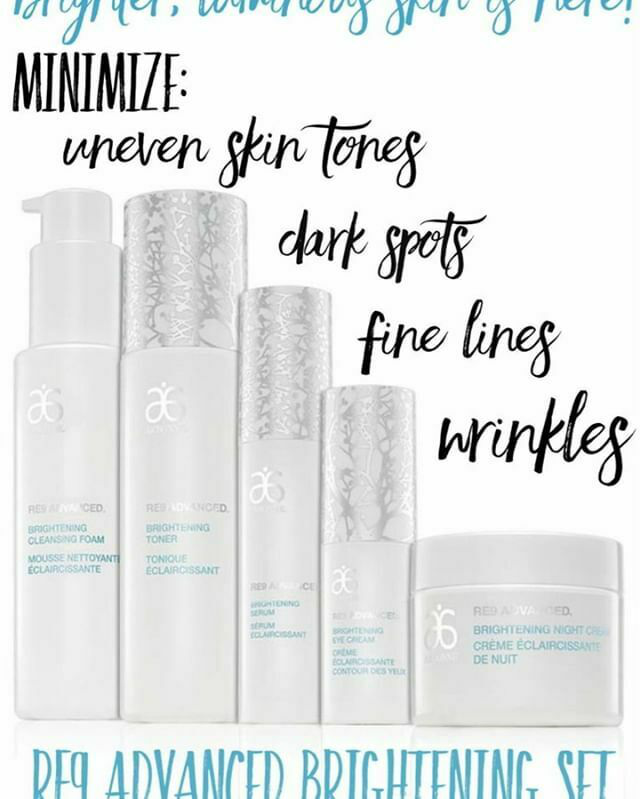

In [54]:
Image.open('/data/old-data/images/b3BbMZ7mzH3K4SVWrhL2rrNp')

In [84]:
snapshots_df = pd.read_csv('/data/old-data/database/snapshots.csv')

In [90]:
snapshots_df.loc[15]

id                                                                       2393
name                                       macroscopic training manifest only
created_at                                         2020-01-21 06:53:53.817577
updated_at                                         2020-01-21 07:08:58.820561
slug                                       macroscopic-training-manifest-only
percent_sample_per_group                                                  NaN
fixed_sample_per_group                                                    NaN
tag_query                   first-gate:unhealthy-skin and not (aip:test or...
user_id                                                                    13
dictionary_names                                                          NaN
dictionary_queries                                                        NaN
excluded_snapshot_ids                                                     NaN
processing_status                                               